In [4]:
#DATA: https://support.10xgenomics.com/single-cell-gene-expression/datasets/2.1.0/t_3k
#TUTORIAL: http://cf.10xgenomics.com/supp/cell-exp/megacell_tutorial-1.0.1.html
# HUMAN T-Cells
!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_filtered_gene_bc_matrices.tar.gz

--2018-06-22 12:24:00--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 52.84.122.185, 52.84.122.71, 52.84.122.77, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|52.84.122.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13257230 (13M) [application/x-tar]
Saving to: ‘t_3k_filtered_gene_bc_matrices.tar.gz’

100%[======================================>] 13,257,230  54.3MB/s   in 0.2s   

2018-06-22 12:24:01 (54.3 MB/s) - ‘t_3k_filtered_gene_bc_matrices.tar.gz’ saved [13257230/13257230]



In [5]:
!tar -xzf t_3k_filtered_gene_bc_matrices.tar.gz

In [438]:
#!rm t_3k_filtered_gene_bc_matrices.tar.gz
#!rm -r analysis
!rm -r human_t_3k_filtered_gene_bc_matrices/

In [96]:
import csv
import os
import scipy.io
from scipy.sparse import coo_matrix
mat = scipy.io.mmread(os.path.join("filtered_gene_bc_matrices/GRCh38/matrix.mtx"))

In [211]:
import numpy as np
genes_path = "filtered_gene_bc_matrices/GRCh38/genes.tsv"
barcodes_path = "filtered_gene_bc_matrices/GRCh38/barcodes.tsv"
gene_ids = np.array([row[0] for row in csv.reader(open(genes_path), delimiter="\t")])
gene_names = np.array([row[1] for row in csv.reader(open(genes_path), delimiter="\t")])
barcodes = np.array([row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")])
mat_expr = mat.tocsc()

In [212]:
import collections
GeneBCMatrix = collections.namedtuple('GeneBCMatrix', ['gene_ids', 'gene_names', 'barcodes', 'matrix'])
full_gene_bc_matrix = GeneBCMatrix(gene_ids, gene_names, barcodes, mat_expr)

In [405]:
def get_expression(gbm, gene_name):
    #gene_index = gbm.gene_names.index(gene_name)
    #if len(gene_indices) == 0:
     #   raise Exception("%s was not found in list of gene names." % gene_name)
    #return gbm.matrix[gene_index, :].toarray().squeeze()
    gene_indices = np.where(gbm.gene_names == gene_name)[0]
    if len(gene_indices) == 0:
        #raise Exception("%s was not found in list of gene names." % gene_name)!!!!
        return [0] * len(gbm.barcodes)
    return gbm.matrix[gene_indices[0], :].toarray().squeeze()

In [214]:
print(len(full_gene_bc_matrix.gene_names))
print(len(full_gene_bc_matrix.barcodes))

33694
3555


In [215]:
# axis 0 is columns, axis 1 is rows
umis_per_cell = np.asarray(full_gene_bc_matrix.matrix.sum(axis=0)).squeeze()
genes_per_cell = np.asarray((full_gene_bc_matrix.matrix > 0).sum(axis=0)).squeeze()
print(umis_per_cell)

[ 4573  3953  4326 ... 11171  3428  4851]


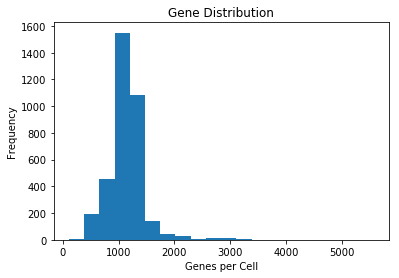

In [216]:
import matplotlib.pyplot as plt
plt.hist(genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()

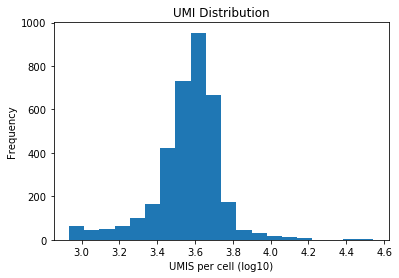

In [217]:
# plot UMIs per cell
plt.hist(np.log10(umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

In [115]:
!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_analysis.tar.gz

--2018-06-22 16:11:55--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/t_3k/t_3k_analysis.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 52.84.122.102, 52.84.122.185, 52.84.122.77, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|52.84.122.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16905495 (16M) [application/x-tar]
Saving to: ‘t_3k_analysis.tar.gz’

100%[======================================>] 16,905,495  4.73MB/s   in 3.6s   

2018-06-22 16:11:58 (4.53 MB/s) - ‘t_3k_analysis.tar.gz’ saved [16905495/16905495]



In [116]:
!tar -xzf t_3k_analysis.tar.gz
!rm t_3k_analysis.tar.gz

In [118]:
# load TSNE and graph clustering
import pandas as pd
import csv
import scipy.stats
tsne = pd.read_csv("analysis/tsne/2_components/projection.csv")
clusters = pd.read_csv("analysis/clustering/graphclust/clusters.csv")

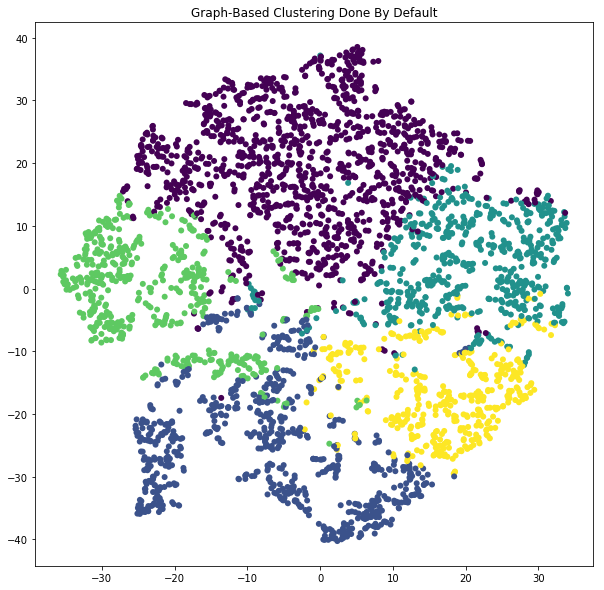

In [294]:
# plot clusters in TSNE space
plt.figure(figsize=(10, 10))
plt.scatter(tsne['TSNE-1'], tsne['TSNE-2'], c=clusters['Cluster'], linewidths=0)
plt.title('Graph-Based Clustering Done By Default')
plt.show()

In [296]:
# subsample matrix for the barcodes corresponding to the largest "sub-tissue" cluster: # 1, 1262 barcodes
subsample = clusters.loc[clusters['Cluster'] == 1].index.values
cl1_gene_bc_matrix = GeneBCMatrix(full_gene_bc_matrix.gene_ids, full_gene_bc_matrix.gene_names, full_gene_bc_matrix.barcodes[subsample], full_gene_bc_matrix.matrix[:, subsample])
print(len(cl1_gene_bc_matrix.gene_names))
print(len(cl1_gene_bc_matrix.barcodes))
#print(cl1_gene_bc_matrix.matrix.shape)

33694
1262


In [297]:
# now subsample matrix on the cell-cycle genes
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3842991/
cell_cycle_genes = np.array(['CCNE1', 'CCNE2', 'E2F2', 'PCNA', 'MCM2', 'HIST1H4B', 'HIST1H4C', 'SLBP', 'RRM2', 'RFC4', 'TOP2A', 'CDC2', 'CCNA2', 'CCNF', 'CCNB1', 'CCNB2', 'BUB1', 'BUB1B', 'CDC25B', 'RAD21', 'CDKN3', 'PTTG1'])
print(cell_cycle_genes)
ccg_subsample = np.where(np.isin(cl1_gene_bc_matrix.gene_names, cell_cycle_genes))[0]
print(ccg_subsample)
cl1_ccg_matrix = GeneBCMatrix(cl1_gene_bc_matrix.gene_ids[ccg_subsample], cl1_gene_bc_matrix.gene_names[ccg_subsample], cl1_gene_bc_matrix.barcodes, cl1_gene_bc_matrix.matrix[ccg_subsample, :])
print(cl1_ccg_matrix.matrix.shape)

['CCNE1' 'CCNE2' 'E2F2' 'PCNA' 'MCM2' 'HIST1H4B' 'HIST1H4C' 'SLBP' 'RRM2'
 'RFC4' 'TOP2A' 'CDC2' 'CCNA2' 'CCNF' 'CCNB1' 'CCNB2' 'BUB1' 'BUB1B'
 'CDC25B' 'RAD21' 'CDKN3' 'PTTG1']
[  480  3255  4308  6462  7002  7196  8051  9009  9925 10426 10433 15294
 15445 23196 24258 24546 25343 27648 29386 29411 31083]
(21, 1262)


In [298]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
# transpose matrix, since samples (rows) should be barcodes (cells)
kmeans_cl1_ccg = KMeans(n_clusters=5).fit(cl1_ccg_matrix.matrix.T)
print(kmeans_cl1_ccg.labels_)
tsne_cl1_ccg = TSNE(n_components=2).fit_transform(cl1_ccg_matrix.matrix.T.todense())
print(tsne_cl1_ccg)

[4 3 3 ... 3 2 4]
[[-38.07147589  -1.50514882]
 [ -0.67194286  26.4363635 ]
 [ 27.29335176  19.73630994]
 ...
 [ 35.22367754  29.67919798]
 [ 27.14793747  -2.90713444]
 [-37.18886674  -1.94501751]]


In [325]:
from sklearn.cluster import AgglomerativeClustering
# transpose matrix, since samples (rows) should be barcodes (cells)
agglom_cl1_ccg = AgglomerativeClustering(n_clusters=5).fit(cl1_ccg_matrix.matrix.T.todense())
from sklearn.cluster import SpectralClustering
# transpose matrix, since samples (rows) should be barcodes (cells)
spectral_cl1_ccg = SpectralClustering(n_clusters=5).fit(cl1_ccg_matrix.matrix.T)

/home/moamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


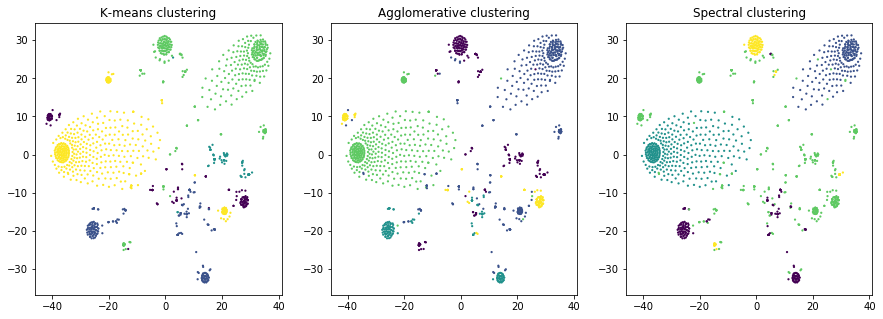

In [326]:
# plot k-means clusters in TSNE space
f, axes = plt.subplots(1, 3, figsize=(5*3, 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
axes[1].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=agglom_cl1_ccg.labels_, s=5, linewidths=0)
axes[1].set_title("Agglomerative clustering")
axes[2].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=spectral_cl1_ccg.labels_, s=5, linewidths=0)
axes[2].set_title("Spectral clustering")
plt.show()

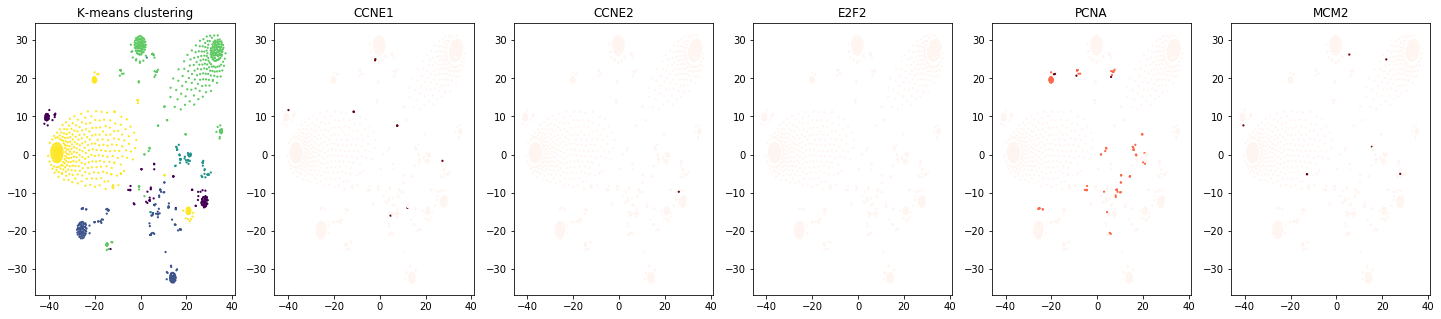

In [321]:
# plot markers
# G1/S phase  - ???
marker_genes = ['CCNE1', 'CCNE2', 'E2F2', 'PCNA', 'MCM2']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(cl1_ccg_matrix, gene)
    axis.scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

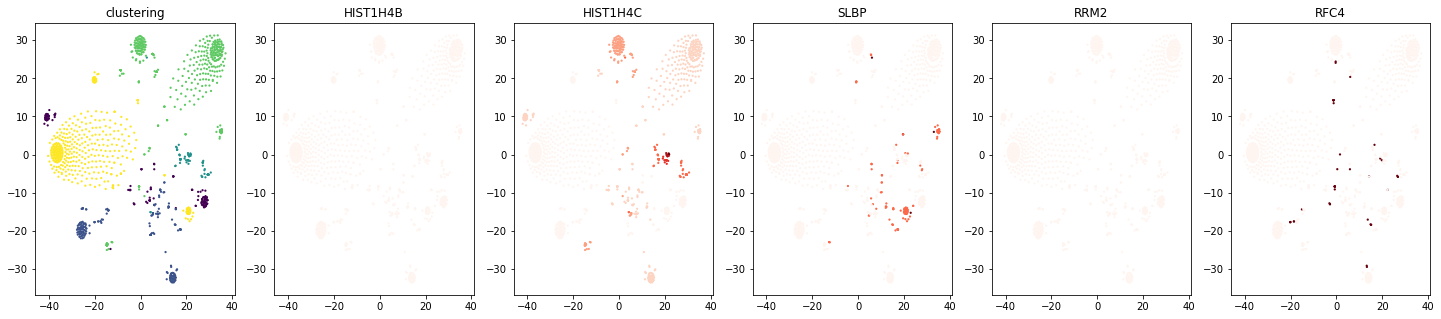

In [317]:
# S-phase - green?
marker_genes = ['HIST1H4B', 'HIST1H4C', 'SLBP', 'RRM2', 'RFC4']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(cl1_ccg_matrix, gene)
    axis.scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

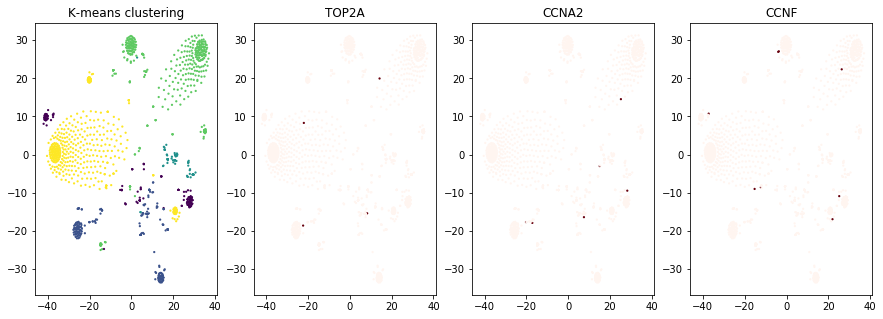

In [318]:
# G2 phase 
marker_genes = ['TOP2A', 'CCNA2', 'CCNF']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(cl1_ccg_matrix, gene)
    axis.scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

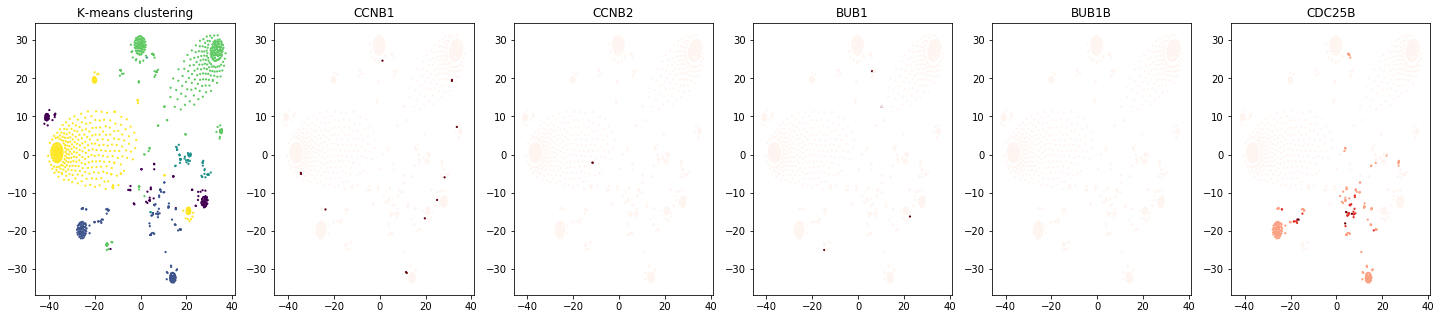

In [319]:
#G2/M phase - blue cluster
marker_genes = ['CCNB1', 'CCNB2', 'BUB1', 'BUB1B', 'CDC25B']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(cl1_ccg_matrix, gene)
    axis.scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

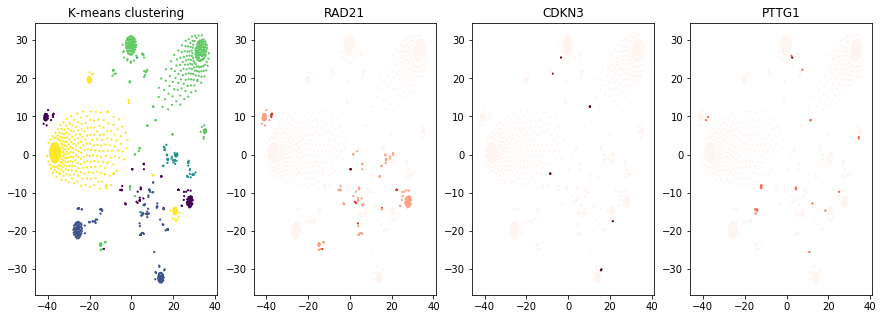

In [320]:
#M/G1 phase - purple cluster
marker_genes = ['RAD21', 'CDKN3', 'PTTG1']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=kmeans_cl1_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(cl1_ccg_matrix, gene)
    axis.scatter(tsne_cl1_ccg[:,0], tsne_cl1_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

In [352]:
l = list(cl1_gene_bc_matrix.gene_names)
bla = set([x for x in l if l.count(x) > 1])
print(bla)

{'ECSCR', 'CRHR1', 'C1QTNF9B-AS1', 'C11orf71', 'IGHV2-70', 'PIK3R3', 'MATR3', 'LINC01422', 'FAM231C', 'PABPC1L2B-AS1', 'PRICKLE2-AS1', 'TIMM10B', 'CYB561D2', 'CFAP99', 'AKR1C3', 'TMEM256-PLSCR3', 'TMBIM4', 'PRICKLE4', 'PGM5-AS1', 'RABL6', 'LINC01297', 'CAPS', 'RGS5', 'FBF1', 'SERPINA3', 'TBC1D26', 'CCDC7', 'LINC00864', 'LINC01481', 'C17orf100', 'RAET1E-AS1', 'ATRIP', 'BLOC1S5', 'SPATA13'}


In [355]:
# force list to contain unique names:
mylist = list(cl1_gene_bc_matrix.gene_names)
newlist = []
for i, v in enumerate(mylist):
    totalcount = mylist.count(v)
    count = mylist[:i].count(v)
    newlist.append(v + "_" + str(count + 1) if totalcount > 1 else v)

In [356]:
# double-check
l = newlist #list(cl1_gene_bc_matrix.gene_names)
bla = set([x for x in l if l.count(x) > 1])
print(bla)

set()


In [359]:
# write out cluster 1 as R-style dense matrix
cl1_dense_df = pd.DataFrame(cl1_gene_bc_matrix.matrix.todense())
cl1_dense_df.columns = cl1_gene_bc_matrix.barcodes
cl1_dense_df.index =  newlist# real gene names not unique!!! cl1_gene_bc_matrix.gene_names
cl1_dense_df.to_csv("tenX_human_t_3k_cl1.csv", sep='\t', index=True, header=True)

In [444]:
# write out the entire dataset as R-style dense matrix
full_dense_df = pd.DataFrame(full_gene_bc_matrix.matrix.todense())
full_dense_df.columns = full_gene_bc_matrix.barcodes
full_dense_df.index =  newlist# real gene names not unique!!! cl1_gene_bc_matrix.gene_names
full_dense_df.to_csv("tenX_human_t_3k_all.csv", sep='\t', index=True, header=True)

ValueError: Length mismatch: Expected axis has 33694 elements, new values have 27998 elements

In [361]:
# try to import the matrix
test_df = pd.read_table("nestorawa_forcellcycle_expressionMatrix.txt", index_col = 0)

In [443]:
print(test_df.index.values)

['GNAI3' 'PBSN' 'CDC45' ... 'GSTM2-PS1' 'VMN1R-PS6' 'C330024D21RIK']


In [441]:
from scipy.sparse import csc_matrix
mat_seurat = csc_matrix(test_df.values)

TypeError: no supported conversion for types: (dtype('O'),)

In [370]:
seurat_bc_matrix = GeneBCMatrix(list(), test_df.index, test_df.columns, mat_seurat)

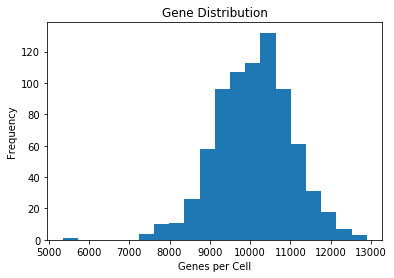

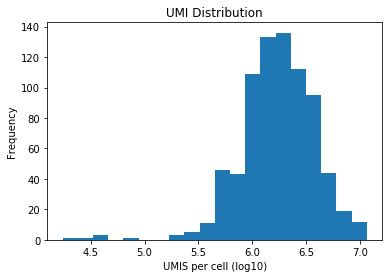

In [434]:
# axis 0 is columns, axis 1 is rows
seurat_umis_per_cell = np.asarray(seurat_bc_matrix.matrix.sum(axis=0)).squeeze()
seurat_genes_per_cell = np.asarray((seurat_bc_matrix.matrix > 0).sum(axis=0)).squeeze()
import matplotlib.pyplot as plt
plt.hist(seurat_genes_per_cell, bins=20)
plt.xlabel('Genes per Cell')
plt.ylabel('Frequency')
plt.title('Gene Distribution')
plt.show()
# plot UMIs per cell
plt.hist(np.log10(seurat_umis_per_cell), bins=20)
plt.xlabel('UMIS per cell (log10)')
plt.ylabel('Frequency')
plt.title('UMI Distribution')
plt.show()

In [374]:
# subsample based on the cell cycle genes
ccg_seurat_subsample = np.where(np.isin(seurat_bc_matrix.gene_names, cell_cycle_genes))[0]
print(ccg_seurat_subsample)
seurat_ccg_matrix = GeneBCMatrix(list(), seurat_bc_matrix.gene_names[ccg_seurat_subsample], seurat_bc_matrix.barcodes, seurat_bc_matrix.matrix[ccg_seurat_subsample, :])
print(seurat_ccg_matrix.matrix.shape)

[  368   489   730  2025  2490  2631  2807  3581  3922  5998  6006  6034
  6227  6503  8753 10689 11659 12122 16547 17928 18412]
(21, 774)


In [375]:
tsne_seurat_ccg = TSNE(n_components=2).fit_transform(seurat_ccg_matrix.matrix.T.todense())
print(tsne_seurat_ccg)

[0 4 0 0 3 2 0 0 0 2 0 3 0 2 0 2 3 2 0 0 0 2 0 0 2 0 2 3 0 0 2 0 2 0 1 3 0
 1 2 0 3 0 0 0 0 0 0 0 2 4 4 2 3 0 0 2 2 0 2 1 2 3 0 2 0 0 0 0 0 0 0 3 0 1
 0 0 0 0 0 0 2 3 0 0 0 0 0 0 0 0 0 3 0 2 0 0 0 0 2 2 0 1 0 0 0 0 0 0 0 2 1
 0 2 2 0 0 3 0 0 3 3 0 1 0 0 0 0 2 0 2 2 0 0 0 2 2 0 2 0 2 0 2 0 0 0 0 0 2
 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 3 2 2 1 0 2 2 1 0 2 0 2 0 0 0 3 0 3 0
 0 2 0 0 0 4 2 0 2 0 0 0 2 3 0 0 0 2 0 2 0 1 2 0 1 0 3 0 3 4 0 0 0 4 0 3 0
 0 0 0 0 0 0 3 2 0 2 2 2 0 3 2 0 2 0 2 0 3 0 0 3 3 0 0 0 0 0 2 0 3 2 0 0 0
 0 0 0 0 2 0 0 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 3 0 3 1 0 0 2
 2 0 0 2 2 2 4 4 2 2 0 0 2 0 0 0 4 2 0 1 2 2 2 0 2 0 2 0 4 0 4 3 2 0 0 3 0
 4 0 3 2 4 2 3 3 3 2 3 0 3 2 2 2 0 3 4 2 0 0 0 0 2 1 0 2 2 3 3 0 2 1 2 2 0
 4 0 3 0 2 0 2 2 0 0 0 0 0 0 2 0 0 0 4 0 0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 2
 0 2 3 0 0 0 0 0 1 4 0 0 0 0 0 0 2 4 2 2 0 0 0 4 2 0 2 3 0 0 0 0 0 2 2 0 0
 0 2 2 0 0 0 2 0 0 0 0 0 0 0 2 0 0 4 2 0 4 2 0 2 0 2 2 0 2 0 0 2 0 0 2 0 2
 0 0 2 0 0 2 0 0 2 2 0 0 

In [377]:
kmeans_seurat_ccg = KMeans(n_clusters=5).fit(seurat_ccg_matrix.matrix.T)
agglom_seurat_ccg = AgglomerativeClustering(n_clusters=5).fit(seurat_ccg_matrix.matrix.T.todense())
spectral_seurat_ccg = SpectralClustering(n_clusters=5).fit(seurat_ccg_matrix.matrix.T)

/home/moamin/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/moamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


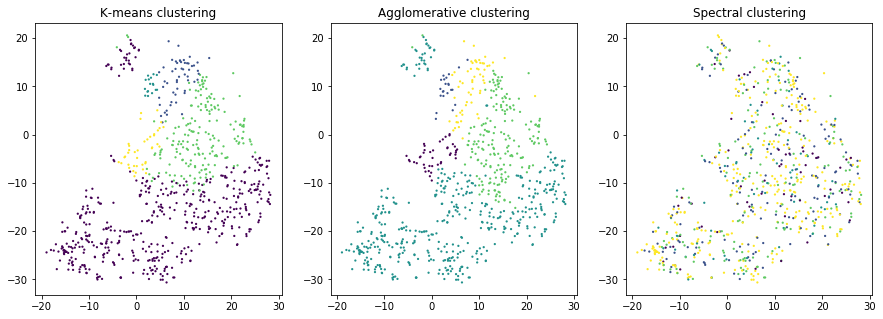

In [378]:
# plot k-means clusters in TSNE space
f, axes = plt.subplots(1, 3, figsize=(5*3, 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
axes[1].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=agglom_seurat_ccg.labels_, s=5, linewidths=0)
axes[1].set_title("Agglomerative clustering")
axes[2].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=spectral_seurat_ccg.labels_, s=5, linewidths=0)
axes[2].set_title("Spectral clustering")
plt.show()

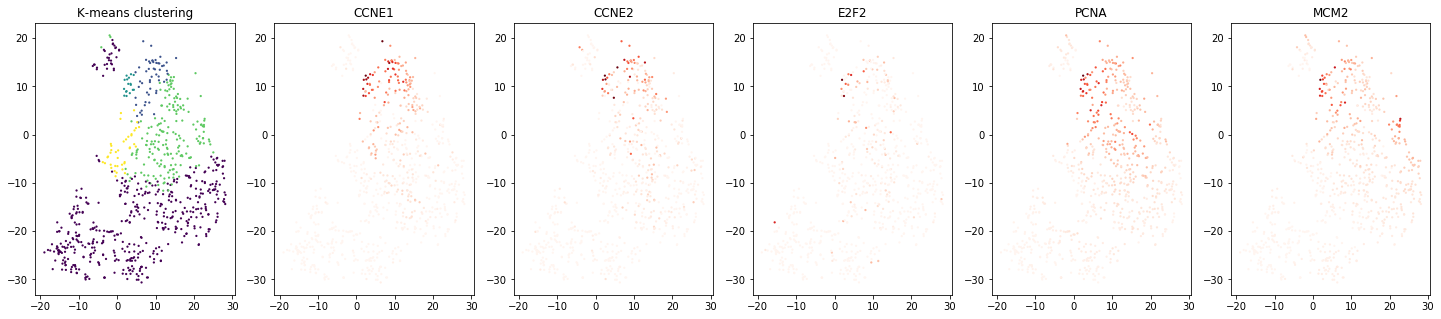

In [381]:
# G1/S phase  - ???
marker_genes = ['CCNE1', 'CCNE2', 'E2F2', 'PCNA', 'MCM2']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_ccg_matrix, gene)
    axis.scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

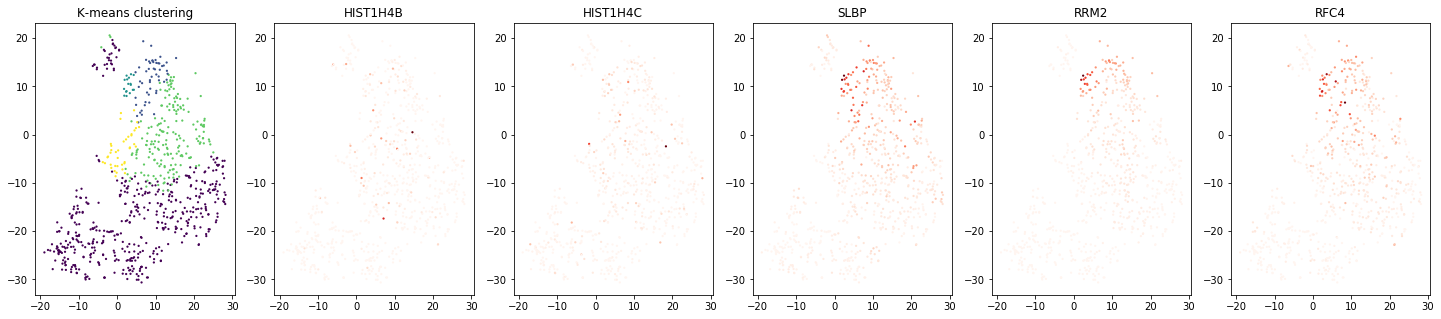

In [382]:
# S-phase - ?
marker_genes = ['HIST1H4B', 'HIST1H4C', 'SLBP', 'RRM2', 'RFC4']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_ccg_matrix, gene)
    axis.scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

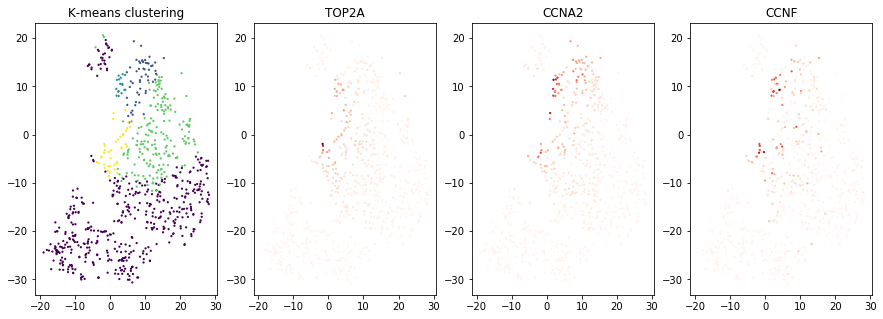

In [383]:
# G2 phase 
marker_genes = ['TOP2A', 'CCNA2', 'CCNF']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_ccg_matrix, gene)
    axis.scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

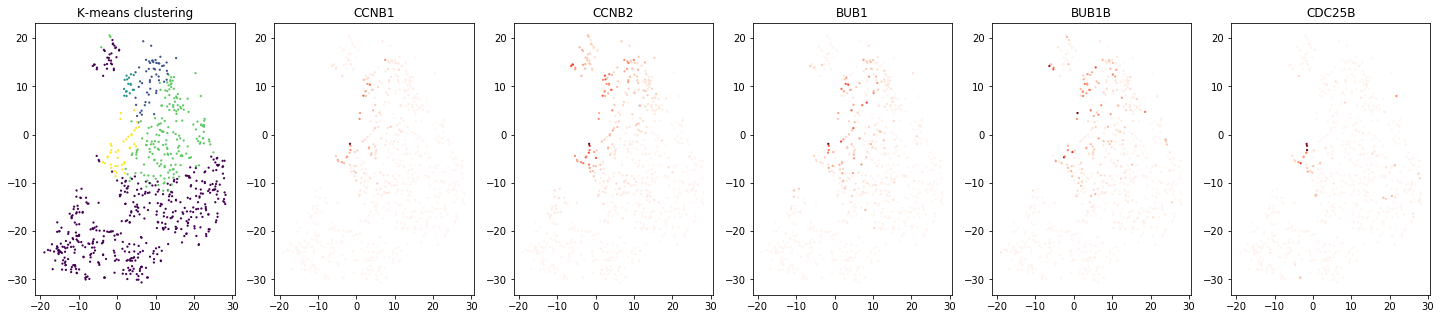

In [384]:
#G2/M phase - 
marker_genes = ['CCNB1', 'CCNB2', 'BUB1', 'BUB1B', 'CDC25B']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_ccg_matrix, gene)
    axis.scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

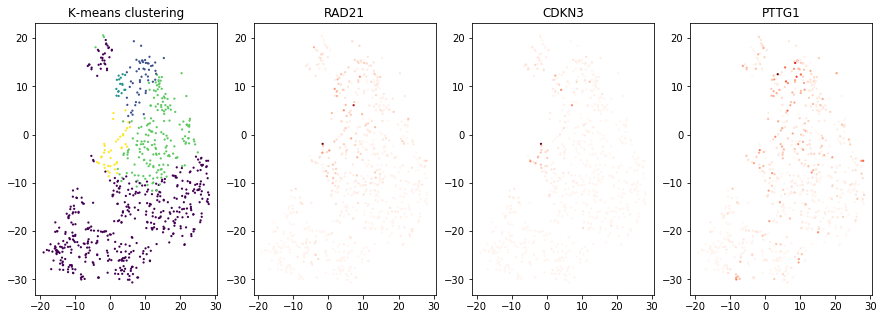

In [385]:
#M/G1 phase - purple cluster
marker_genes = ['RAD21', 'CDKN3', 'PTTG1']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=kmeans_seurat_ccg.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_ccg_matrix, gene)
    axis.scatter(tsne_seurat_ccg[:,0], tsne_seurat_ccg[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

In [397]:
# Ok, now try clustering using just the seurat 2-gene set 
seurat_genes = [line.rstrip('\n') for line in open('regev_lab_cell_cycle_genes.txt')]
s_seurat_genes = seurat_genes[:44]
g2m_seurat_genes = seurat_genes[44:]

In [398]:
# subsample based on the cell cycle genes
their_seurat_subsample = np.where(np.isin(seurat_bc_matrix.gene_names, seurat_genes))[0]
seurat_their_matrix = GeneBCMatrix(list(), seurat_bc_matrix.gene_names[their_seurat_subsample], seurat_bc_matrix.barcodes, seurat_bc_matrix.matrix[their_seurat_subsample, :])


In [395]:
tsne_seurat_their = TSNE(n_components=2).fit_transform(seurat_their_matrix.matrix.T.todense())
kmeans_seurat_their = KMeans(n_clusters=3).fit(seurat_their_matrix.matrix.T)
agglom_seurat_their = AgglomerativeClustering(n_clusters=3).fit(seurat_their_matrix.matrix.T.todense())
spectral_seurat_their = SpectralClustering(n_clusters=3).fit(seurat_their_matrix.matrix.T)

/home/moamin/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/moamin/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


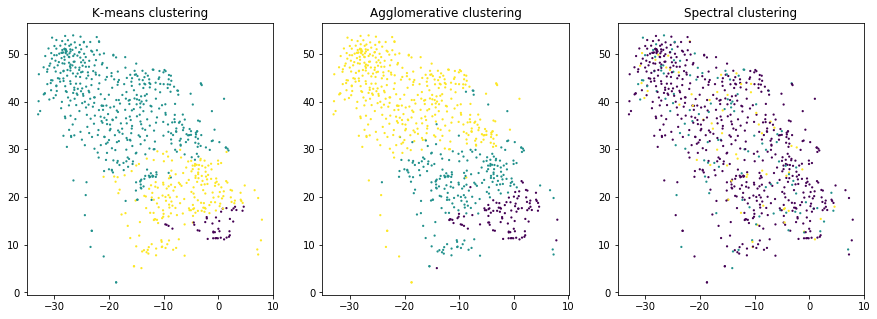

In [396]:
# plot k-means clusters in TSNE space
f, axes = plt.subplots(1, 3, figsize=(5*3, 5))
axes[0].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=kmeans_seurat_their.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
axes[1].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=agglom_seurat_their.labels_, s=5, linewidths=0)
axes[1].set_title("Agglomerative clustering")
axes[2].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=spectral_seurat_their.labels_, s=5, linewidths=0)
axes[2].set_title("Spectral clustering")
plt.show()

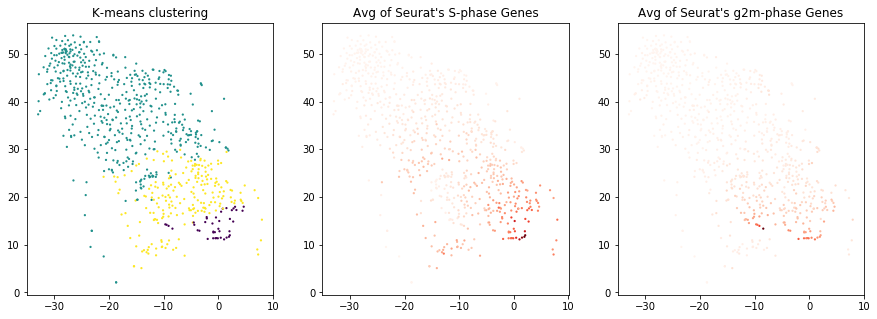

In [412]:
# Bad Idea, To Average ALL the UMI's across a gene set.... try a set of random 5 genes later....
f, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=kmeans_seurat_their.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")

s_seurat_avg_expression = [0] * len(seurat_their_matrix.barcodes)
for gene in s_seurat_genes:
    expr = get_expression(seurat_their_matrix, gene)
    s_seurat_avg_expression = np.add(s_seurat_avg_expression, expr)
s_seurat_avg_expression = np.true_divide(s_seurat_avg_expression, len(s_seurat_genes))
axes[1].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=s_seurat_avg_expression, s=5, linewidths=0, cmap=plt.cm.Reds)
axes[1].set_title("Avg of Seurat's S-phase Genes")

g2m_seurat_avg_expression = [0] * len(seurat_their_matrix.barcodes)
for gene in g2m_seurat_genes:
    expr = get_expression(seurat_their_matrix, gene)
    g2m_seurat_avg_expression = np.add(g2m_seurat_avg_expression, expr)
g2m_seurat_avg_expression = np.true_divide(g2m_seurat_avg_expression, len(g2m_seurat_genes))
axes[2].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=g2m_seurat_avg_expression, s=5, linewidths=0, cmap=plt.cm.Reds)
axes[2].set_title("Avg of Seurat's g2m-phase Genes")

plt.show()

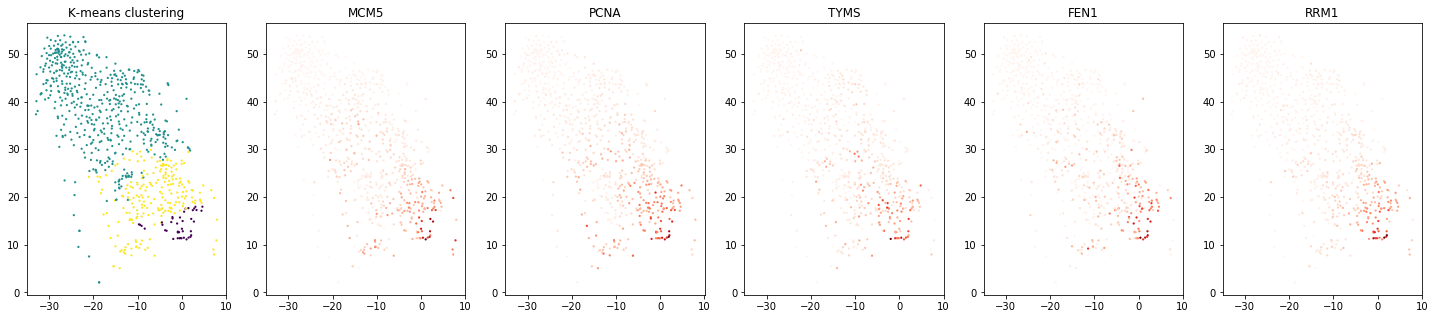

In [413]:
#Random 5 genes from Seurat's S-Phase
marker_genes = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'RRM1']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=kmeans_seurat_their.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_their_matrix, gene)
    axis.scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

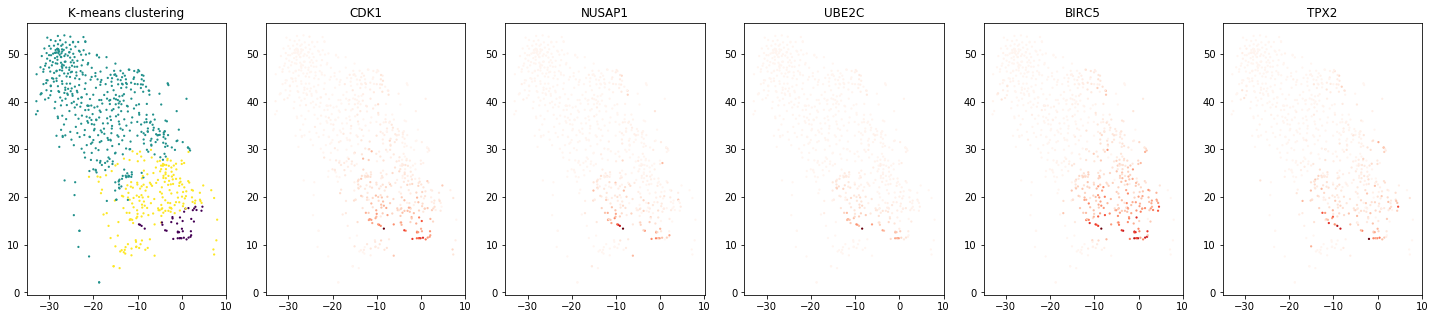

In [414]:
#Random 5 genes from Seurat's G2M Phase
marker_genes = ['CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2']
f, axes = plt.subplots(1, len(marker_genes)+1, figsize=(5*len(marker_genes), 5))
axes[0].scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=kmeans_seurat_their.labels_, s=5, linewidths=0)
axes[0].set_title("K-means clustering")
for gene, axis in zip(marker_genes, axes[1:]):
    expr = get_expression(seurat_their_matrix, gene)
    axis.scatter(tsne_seurat_their[:,0], tsne_seurat_their[:,1], c=expr, s=5, linewidths=0, cmap=plt.cm.Reds)
    axis.set_title(gene)
plt.show()

In [425]:
# import the E18 mouse cells and convert to R format
!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/neurons_2000/neurons_2000_filtered_gene_bc_matrices.tar.gz
#!wget --no-check-certificate http://cf.10xgenomics.com/samples/cell-exp/2.1.0/neurons_900/neurons_900_filtered_gene_bc_matrices.tar.gz

--2018-07-16 14:31:10--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/neurons_2000/neurons_2000_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 54.192.49.15, 54.192.49.108, 54.192.49.74, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|54.192.49.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16189449 (15M) [application/x-tar]
Saving to: ‘neurons_2000_filtered_gene_bc_matrices.tar.gz’

100%[======================================>] 16,189,449  83.5MB/s   in 0.2s   

2018-07-16 14:31:10 (83.5 MB/s) - ‘neurons_2000_filtered_gene_bc_matrices.tar.gz’ saved [16189449/16189449]



In [426]:
!tar -xzf neurons_2000_filtered_gene_bc_matrices.tar.gz

In [427]:
!rm neurons_2000_filtered_gene_bc_matrices.tar.gz

In [428]:
import csv
import os
import scipy.io
from scipy.sparse import coo_matrix
mat_mouse = scipy.io.mmread(os.path.join("filtered_gene_bc_matrices/mm10/matrix.mtx"))

In [429]:
import numpy as np
genes_path = "filtered_gene_bc_matrices/mm10/genes.tsv"
barcodes_path = "filtered_gene_bc_matrices/mm10/barcodes.tsv"
gene_ids = np.array([row[0] for row in csv.reader(open(genes_path), delimiter="\t")])
gene_names = np.array([row[1] for row in csv.reader(open(genes_path), delimiter="\t")])
barcodes = np.array([row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")])
mat_mouse_expr = mat_mouse.tocsc()

In [439]:
# force list to contain unique names:
mylist = [x.upper() for x in list(gene_names)]
newlist = []
for i, v in enumerate(mylist):
    totalcount = mylist.count(v)
    count = mylist[:i].count(v)
    newlist.append(v + "_" + str(count + 1) if totalcount > 1 else v)

mouse_df = pd.DataFrame(mat_mouse_expr.todense())
mouse_df.columns = barcodes
mouse_df.index =  newlist# real gene names not unique!!! cl1_gene_bc_matrix.gene_names
mouse_df.to_csv("tenX_mouse_e18brain_2k.csv", sep='\t', index=True, header=True)

In [ ]:
# Seurat Steps

# Filter cells - remove it has too few genes expressed?  maybe just don't characterize them

#“LogNormalize”: normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.
# takes ln of gene expression divided by 10,000 * sum of all genes for this cell

# Scale:
# for each gene, (r - rowMean) / rowSdev;, -> Z score;  caps at max of 10
# can optionally regress the effect of things like cell cycle score, nUmi/cell, mitochondrial content....

# scnorm is another R package to check out, seems fine, uses K to normalize genes in groups 
#https://www.biostat.wisc.edu/~kendzior/SCNORM/SCnorm_vignette.pdf

# they run the PC on the set of cell cycle genes only!!!!

# Phase assignment: Tirosh Science paper, 2016 - this is where the S2 and G2M lists come from
based on the following studies:

16 E. Z. Macosko, A. Basu, R. Satija, J. Nemesh, K. Shekhar, M. Goldman, I. Tirosh, A. R.
Bialas, N. Kamitaki, E. M. Martersteck, J. J. Trombetta, D. A. Weitz, J. R. Sanes, A. K.
Shalek, A. Regev, S. A. McCarroll, Highly parallel genome-wide expression profiling of
individual cells using nanoliter droplets. Cell 161, 1202–1214 (2015). Medline
doi:10.1016/j.cell.2015.05.002    
    
63. M. S. Kowalczyk, I. Tirosh, D. Heckl, T. N. Rao, A. Dixit, B. J. Haas, R. K. Schneider, A. J.
Wagers, B. L. Ebert, A. Regev, Single-cell RNA-seq reveals changes in cell cycle and
differentiation programs upon aging of hematopoietic stem cells. Genome Res. 25, 1860–
1872 (2015). Medline doi:10.1101/gr.192237.115

We thus
defined a core set of 43 G1/S and 55 G2/M genes that included those genes that were detected in
the corresponding expression clusters in all four datasets from the three studies described above
(Table S5). Averaging the relative expression of these gene-sets revealed cells that express
primarily one of those programs, or both, while the majority of the cells do not express either of
those programs (Fig. S4). We classified cells by the maximal expression of those two programs
into non-cycling (E<1 or FDR>0.05) and cycling (E>1 and FDR<0.05) which were further
divided into those with a low cell cycle signal (1<E<2), which are likely cycling but may include
some false positives or arrested cells, and those with a high signal for the cell cycle (E>2) which
we consider as confidently cycling cells.

# Now, lets look at what the package does:
# Cell Cycle Scoring - if negative, give it G1 label; otherwise, pick the max of Sscore and G2mscore for label

# get data matrix, make sure genes we are selecting for (all S markers for example), are present

# ctrl size = 100 entrich.name ='Cell Cycle', genes.list (S and G2M lists), ctrl.size - shorter of the two lists
# cluster length = lengs of genes.list or 2?  genes.pool - all genes in matrix

# get an avg of ALL genes across cells, order the genes by their avg expression, divide into 25(def) bins
# get a control set of genes the size of S and the size of G2M, randomly sampled from the buckets of genes
# with the same average expression

# scores object:  rows is 2 for two categories, columns are all the cells in the matrix, 
# for each cell, get the average expression of the genes in real set, and in the control set

# the S-score is then average expression of S-genes for this cell minus the average expression of control genes set

In [ ]:
# nice circle graph of cell cycle genes: 1134 genes
http://genome-www.stanford.edu/Human-CellCycle/HeLa/images/figure15.html